In [9]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload
import imblearn as imb
# print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from rdkit import Chem
from rdkit.Chem import Draw
import sys
sys.path.append('../')
import utils
from sklearn.model_selection import GridSearchCV
from VisUtils import *
from split_data import *
from RF_GSCV import *
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


# Load inhibition data 

In [3]:
split_path = '../../../../data/NEK_data_4Berkeley/NEK2/'
split_path = '../../../../data/NEK_data_4Berkeley/NEK2/inhib'
train_x_df = pd.read_csv(split_path+"/inhib_train_x_scaledoriginal.csv", header=None)
train_y_df= pd.read_csv(split_path+"/inhib_train_y_scaledoriginal.csv", header=None)
test_x_df= pd.read_csv(split_path+"/inhib_test_x_scaledoriginal.csv", header=None)
test_y_df= pd.read_csv(split_path+"/inhib_test_y_scaledoriginal.csv", header=None)
train_x = train_x_df.to_numpy()
train_y = train_y_df.to_numpy().reshape(-1)
test_x = test_x_df.to_numpy()
test_y = test_y_df.to_numpy().reshape(-1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape


((1636, 306), (1636,), (408, 306), (408,))

In [ ]:
# # Scale data
# x_df = pd.concat([train_x_df, test_x_df])

# scaling=StandardScaler()
 
# # Use fit and transform method 
# scaling.fit(x_df)
# Scaled_data=scaling.transform(x_df)
# train_x = scaling.transform(train_x_df)
# test_x = scaling.transform(test_x_df) 

# train_y = train_y_df.to_numpy().flatten()
# test_y = test_y_df.to_numpy().flatten()


In [15]:
# # # back to df for saving 
# train_x_df = pd.DataFrame(train_x) 
# train_y_df = pd.DataFrame(train_y) 
# test_y_df = pd.DataFrame(test_y)
# test_x_df = pd.DataFrame(test_x)

# train_x_df.to_csv(split_path+'inhib_train_x_scaledoriginal.csv', index=False, header=False)
# train_y_df.to_csv(split_path+'inhib_train_y_scaledoriginal.csv', index=False, header=False) 
# test_y_df.to_csv(split_path+'inhib_test_y_scaledoriginal.csv', index=False, header=False) 
# test_x_df.to_csv(split_path+'inhib_test_x_scaledoriginal.csv', index=False, header=False) 
# train_y_df.shape, test_y_df.shape, test_x_df.shape

((1635, 1), (409, 1), (409, 306))

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.946, precision: 0.636, recall: 0.500, sensitivity: 0.500, specificity: 0.979


<Axes: title={'center': 'NEK2 Inhib Test: Basic RF'}, xlabel='Predicted label', ylabel='True label'>

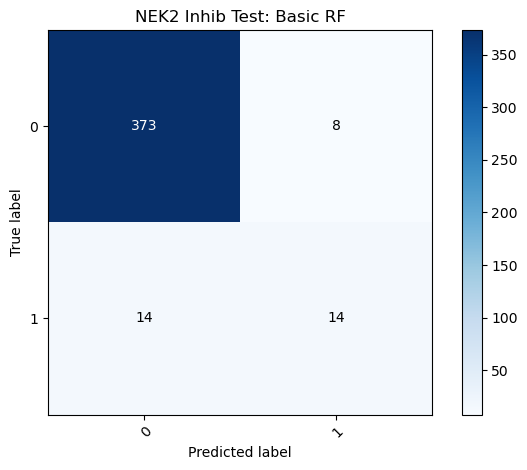

In [16]:
rf_basic100est = rf_models(train_x, train_y, test_x, test_y, 'basic RF', {}, 'inhibition')
# plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='NEK2 Binding Train: Basic RF')
plot_confusion_matrix(test_y, rf_basic100est['test_pred'], ['0','1'], title='NEK2 Inhib Test: Basic RF')

In [7]:
max_depths = [20,50,100]
n_estimators = [100,200,500]
max_features = [50,100,300]

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.915, precision: 0.125, recall: 0.167, sensitivity: 0.167, specificity: 0.948
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.905, precision: 0.105, recall: 0.167, sensitivity: 0.167, specificity: 0.937
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.908, precision: 0.111, recall: 0.167, sensitivity: 0.167, specificity: 0.941


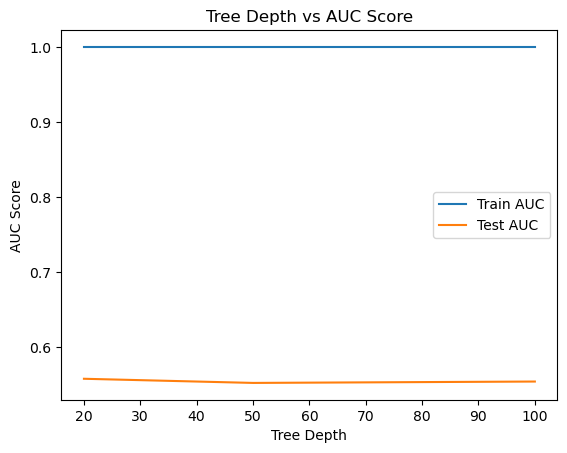

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.912, precision: 0.118, recall: 0.167, sensitivity: 0.167, specificity: 0.945
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.912, precision: 0.118, recall: 0.167, sensitivity: 0.167, specificity: 0.945
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.908, precision: 0.111, recall: 0.167, sensitivity: 0.167, specificity: 0.941


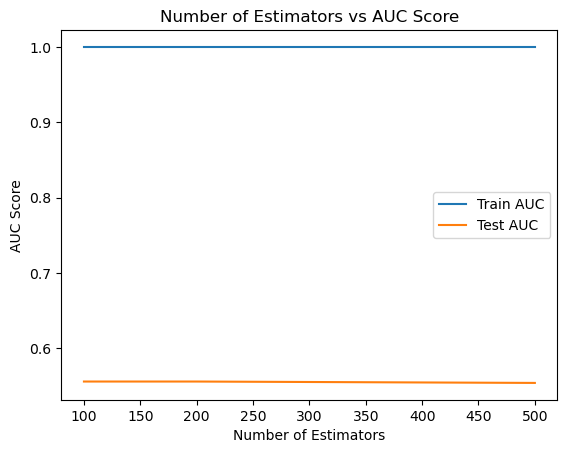

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.958, precision: 0.500, recall: 0.083, sensitivity: 0.083, specificity: 0.996
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.958, precision: 0.500, recall: 0.083, sensitivity: 0.083, specificity: 0.996


In [ ]:

rf_plots(train_x, train_y, test_x, test_y, max_depths, n_estimators, max_features, 'basic RF', parameters={}, dataset_type='inhibition')

# Reduced param grid for grid search - RUN IN BASH SCRIPT 

In [ ]:
param_grid = {
    'n_estimators': np.linspace(100, 2000, 3, dtype = int),
    'max_depth': [20, 100, 200, 220],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 5],
    'criterion': ['gini','entropy']
}

In [6]:
save_file = 'atom_nek2inhib_rf_basic_best.pkl'
# rf_basicbest = find_best_models(train_x, train_y, test_x, test_y, 'basic RF', {}, param_grid,  save_file, 2)
# save_model(rf_basicbest['best_model'], save_file)

TRAIN: accuracy: 0.971, precision: 0.856, recall: 0.688, sensitivity: 0.688, specificity: 0.991
TEST: accuracy: 0.975, precision: 0.909, recall: 0.714, sensitivity: 0.714, specificity: 0.995


<Figure size 600x400 with 0 Axes>

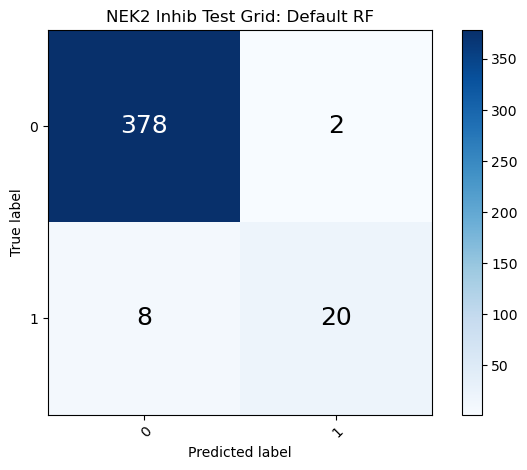

In [10]:
with open('saved_models/'+save_file, 'rb') as f: 
    rf_basicbest = pickle.load(f) 
grid_results = rf_results2(rf_basicbest, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, grid_results['test_pred'], ['0','1'], title='NEK2 Inhib Test Grid: Default RF')



# Basic RF + classweight balanced 

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.946, precision: 0.650, recall: 0.464, sensitivity: 0.464, specificity: 0.982


<Figure size 600x400 with 0 Axes>

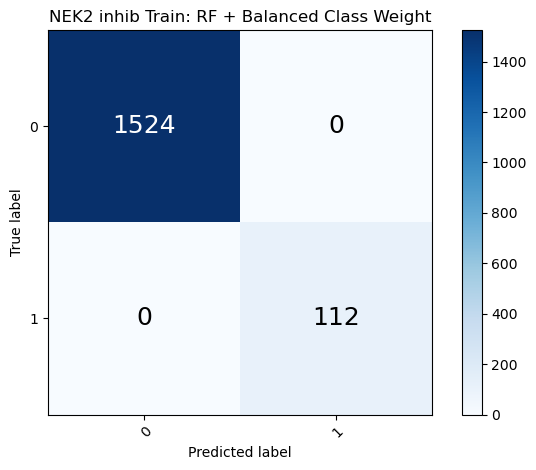

<Figure size 600x400 with 0 Axes>

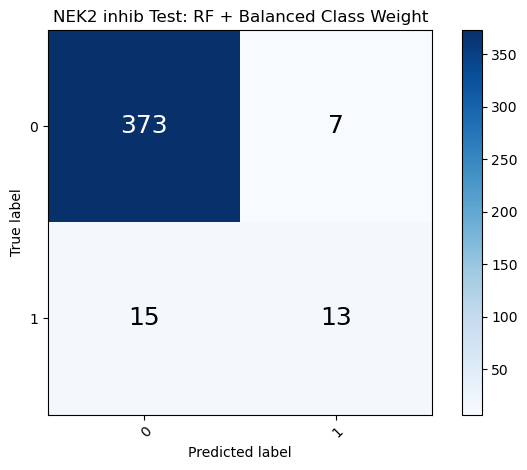

In [11]:
brf_model_BCW = rf_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, 'inhibition')
plot_confusion_matrix(train_y, brf_model_BCW['train_pred'], ['0','1'], title='NEK2 inhib Train: RF + Balanced Class Weight')
plot_confusion_matrix(test_y, brf_model_BCW['test_pred'], ['0','1'], title='NEK2 inhib Test: RF + Balanced Class Weight')

TRAIN: accuracy: 0.983, precision: 0.868, recall: 0.884, sensitivity: 0.884, specificity: 0.990
TEST: accuracy: 0.998, precision: 0.966, recall: 1.000, sensitivity: 1.000, specificity: 0.997


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<Figure size 600x400 with 0 Axes>

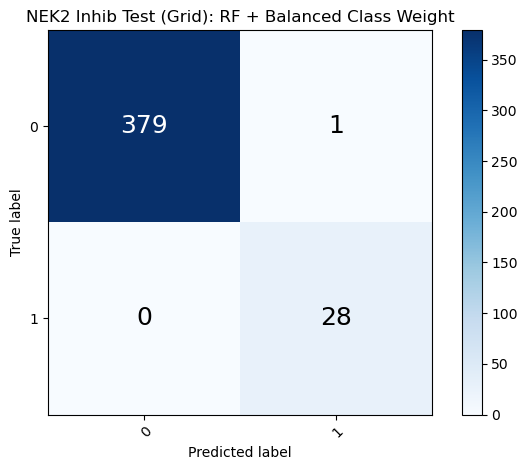

In [13]:
save_file2 = 'atom_nek2inhibition_rf_basicBCW_best.pkl'
# rf_basicBCWbest = find_best_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, param_grid,  save_file2, 2)
# save_model(rf_basicBCWbest['best_model'], save_file2)

with open('saved_models/'+save_file2, 'rb') as f: 
    rf_basicBCWbest = pickle.load(f) 
grid_results2 = rf_results2(rf_basicBCWbest, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, grid_results2['test_pred'], ['0','1'], title='NEK2 Inhib Test (Grid): RF + Balanced Class Weight')



# Balanced Random Forest Classifier

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.956, precision: 0.750, recall: 0.536, sensitivity: 0.536, specificity: 0.987


<Figure size 600x400 with 0 Axes>

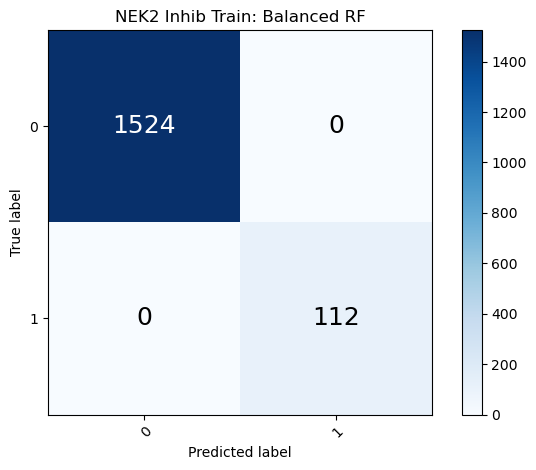

<Figure size 600x400 with 0 Axes>

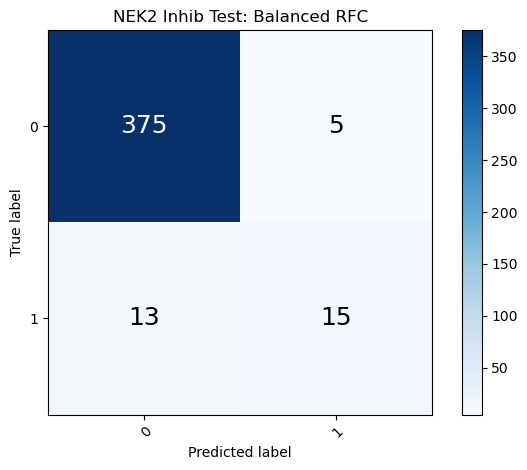

In [14]:
brf_model = rf_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {}, 'inhibition')
plot_confusion_matrix(train_y, brf_model['train_pred'], ['0','1'], title='NEK2 Inhib Train: Balanced RF')
plot_confusion_matrix(test_y, brf_model['test_pred'], ['0','1'], title='NEK2 Inhib Test: Balanced RFC')

TRAIN: accuracy: 0.971, precision: 0.856, recall: 0.688, sensitivity: 0.688, specificity: 0.991
TEST: accuracy: 0.975, precision: 0.909, recall: 0.714, sensitivity: 0.714, specificity: 0.995


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<Figure size 600x400 with 0 Axes>

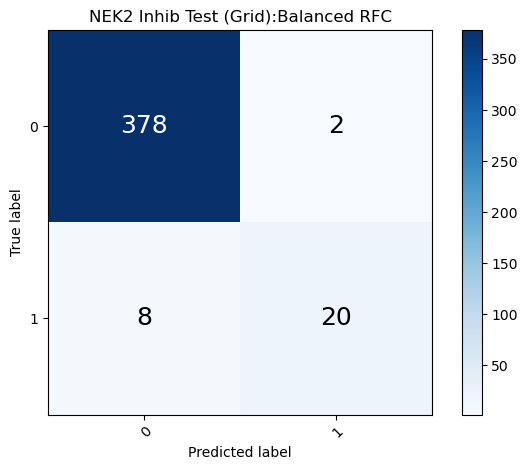

In [15]:
save_file3 = 'atom_nek2inhib_BRFC_best.pkl'
# brfc_best = find_best_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {}, param_grid,  save_file3, 2)
# save_model(brfc_best['best_model'], save_file3)
with open('saved_models/'+save_file3, 'rb') as f: 
    brfc_best = pickle.load(f) 
grid_results3 = rf_results2(brfc_best, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, grid_results3['test_pred'], ['0','1'], title='NEK2 Inhib Test (Grid):Balanced RFC')



# Try BRFC with balanced class weight & bootstrap

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.944, precision: 0.619, recall: 0.464, sensitivity: 0.464, specificity: 0.979


<Figure size 600x400 with 0 Axes>

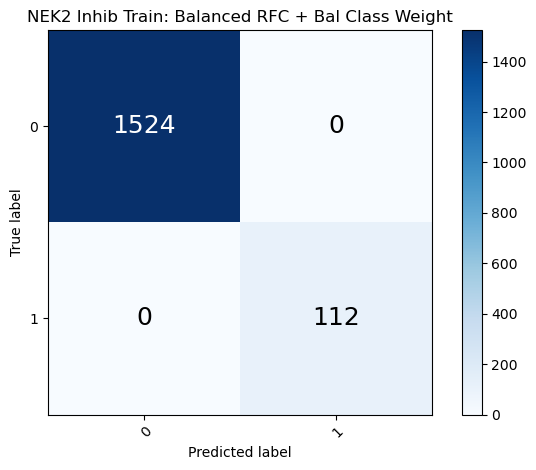

<Figure size 600x400 with 0 Axes>

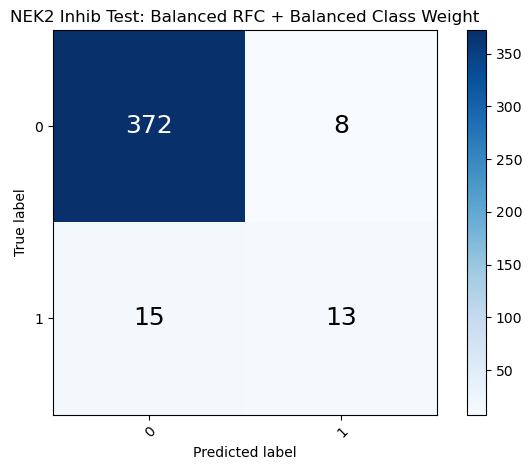

In [16]:
brf_modelCWB = rf_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {'class_weight':'balanced', 'bootstrape':'True'}, 'inhibition')
plot_confusion_matrix(train_y, brf_modelCWB['train_pred'], ['0','1'], title='NEK2 Inhib Train: Balanced RFC + Bal Class Weight')
plot_confusion_matrix(test_y, brf_modelCWB['test_pred'], ['0','1'], title='NEK2 Inhib Test: Balanced RFC + Balanced Class Weight')

In [24]:
# temp_nek2inhib_MOE = {'default_RF':rf_basic100est['model'],
#                             'rf_bcw':brf_model_BCW['model'],
#                              'BRFC': brf_model['model'],
#                             'BRFC_bcw':brf_modelCWB['model']}

# with open('temp_nek2inhib_originalmodels.pkl', 'wb') as f: 
#     pickle.dump(temp_nek2inhib_MOE, f)

TRAIN: accuracy: 0.982, precision: 0.861, recall: 0.884, sensitivity: 0.884, specificity: 0.990
TEST: accuracy: 0.998, precision: 0.966, recall: 1.000, sensitivity: 1.000, specificity: 0.997


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<Figure size 600x400 with 0 Axes>

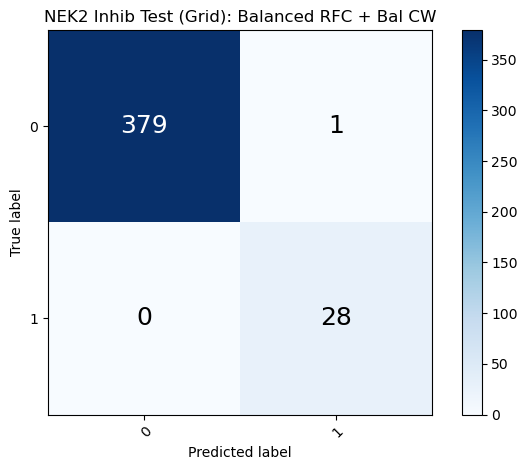

In [17]:
save_file4 = 'atom_nek2inhib_BRFC_BCW_best.pkl'
# brfc_BCW_best = find_best_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {'class_weight':'balanced', 'bootstrape':'True'}, param_grid,  save_file4, 2)
# save_model(brfc_BCW_best['best_model'], save_file4)
with open('saved_models/'+save_file4, 'rb') as f: 
    brfc_BCW_best = pickle.load(f) 
grid_results4 = rf_results2(brfc_BCW_best, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, grid_results4['test_pred'], ['0','1'], title='NEK2 Inhib Test (Grid): Balanced RFC + Bal CW')



In [12]:
# max depth was default 1-- 


In [20]:
nek2inhib_models = {'default_RF':rf_basicbest, 'rf_bcw':rf_basicBCWbest,
                              'BRFC':brfc_best, 'BRFC_bcw':brfc_BCW_best}

with open('nek2inhib_gridmodels.pkl', 'wb') as f:
    pickle.dump(nek2inhib_models, f)


In [19]:
nek2inhib_models

{'default_RF': RandomForestClassifier(bootstrap=False, max_depth=20, max_features=None,
                        min_samples_leaf=5, n_estimators=1050),
 'rf_bcw': RandomForestClassifier(bootstrap=False, class_weight='balanced',
                        criterion='entropy', max_depth=220, max_features=None,
                        min_samples_leaf=2, min_samples_split=4),
 'BRFC': RandomForestClassifier(bootstrap=False, max_depth=200, max_features=None,
                        min_samples_leaf=5, min_samples_split=4),
 'BRFC_bcw': RandomForestClassifier(bootstrap=False, class_weight='balanced',
                        criterion='entropy', max_depth=200, max_features=None,
                        min_samples_leaf=2)}